In [ ]:
# Nonlinear dimension reduction with autoencoders
# Author: Friedrich Geiecke
# Date: 2 April 2025

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
import pandas as pd

# Set random seed
np.random.seed(100)
tf.random.set_seed(100)

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Reshape 28x28 to 784 and normalize
x_train = x_train.reshape((x_train.shape[0], 784)).astype("float32") / 255
x_test = x_test.reshape((x_test.shape[0], 784)).astype("float32") / 255

print(f"{x_train.shape[0]} train observations")
print(f"{x_test.shape[0]} test observations")


In [6]:
# --- PCA ---
pca = PCA()
pca_output = pca.fit_transform(x_train)

Z_pca = pca_output[:, :2]
R_pca = np.dot(Z_pca, pca.components_[:2, :]) + pca.mean_

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Build the autoencoder using the Functional API
inputs = keras.Input(shape=(784,), name="input_layer")
x = layers.Dense(512, activation="elu")(inputs)
x = layers.Dense(128, activation="elu")(x)
bottleneck = layers.Dense(2, activation="linear", name="bottleneck")(x)

x = layers.Dense(128, activation="elu")(bottleneck)
x = layers.Dense(512, activation="elu")(x)
outputs = layers.Dense(784, activation="sigmoid", name="output_layer")(x)

autoencoder = keras.Model(inputs, outputs, name="autoencoder_model")
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# Fit the autoencoder
autoencoder.fit(
    x_train, x_train,
    epochs=8,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# Extract the encoder separately
encoder = keras.Model(inputs=autoencoder.input, outputs=bottleneck)

# Now you can get the lower-dimensional representation
Z_ae = encoder.predict(x_train)
R_ae = autoencoder.predict(x_train)

Model: "autoencoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 936,466 (3.57 MB)

 Trainable params: 936,466 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0679 - val_loss: 0.0491
Epoch 2/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0481 - val_loss: 0.0446
Epoch 3/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0443 - val_loss: 0.0426
Epoch 4/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0424 - val_loss: 0.0414
Epoch 5/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0412 - val_loss: 0.0408
Epoch 6/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0404 - val_loss: 0.0399
Epoch 7/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0398 - val_loss: 0.0393
Epoch 8/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0392 - val_loss: 0.0389
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


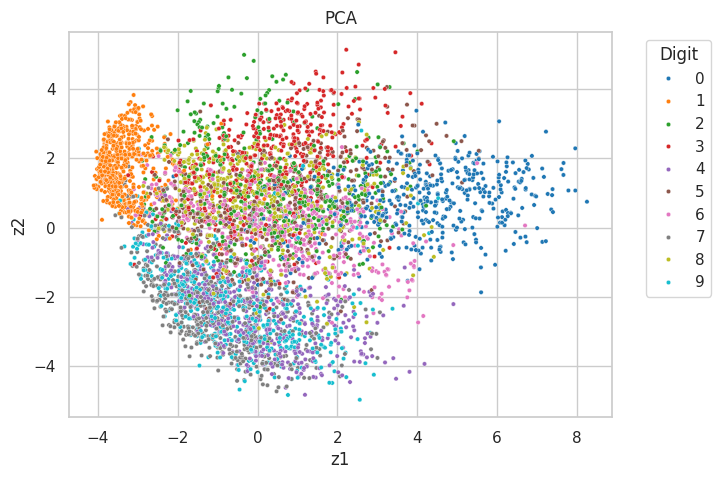

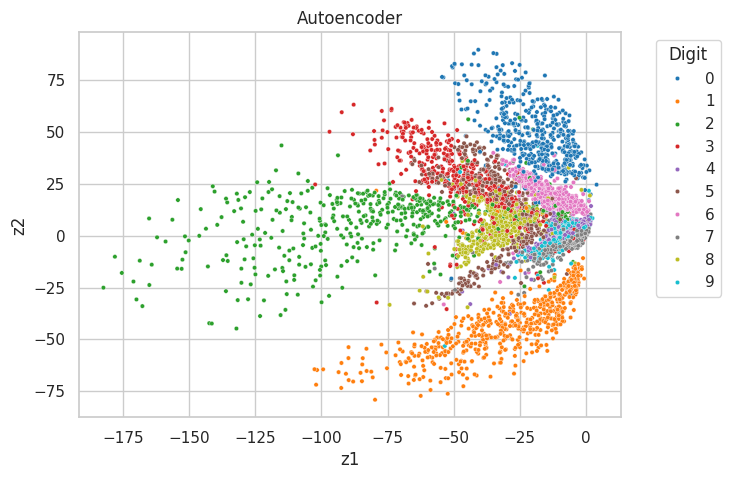

In [10]:
# --- Visualisation: Low dimensional representations ---
plot_data = pd.DataFrame({
    'z1_pca': Z_pca[:5000, 0],
    'z2_pca': Z_pca[:5000, 1],
    'z1_ae': Z_ae[:5000, 0],
    'z2_ae': Z_ae[:5000, 1],
    'Digit': y_train[:5000]
})

import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(7, 5))
sns.scatterplot(data=plot_data, x="z1_pca", y="z2_pca", hue="Digit", palette="tab10", s=10)
plt.title("PCA")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(data=plot_data, x="z1_ae", y="z2_ae", hue="Digit", palette="tab10", s=10)
plt.title("Autoencoder")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

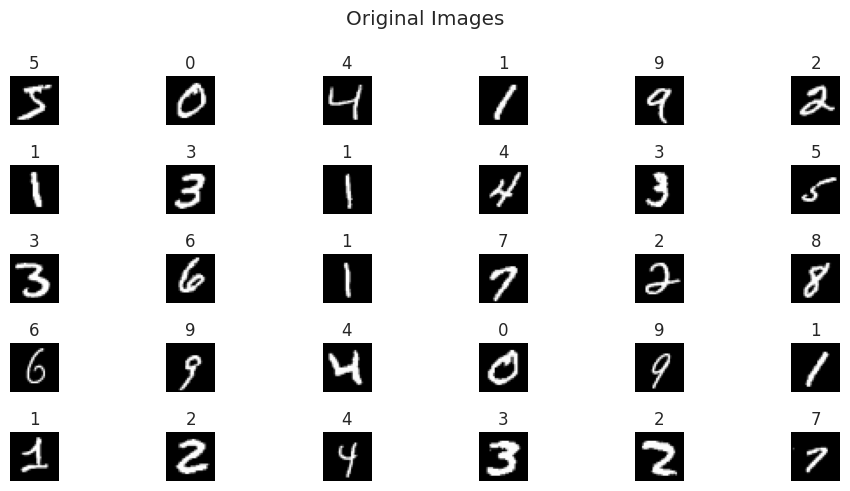

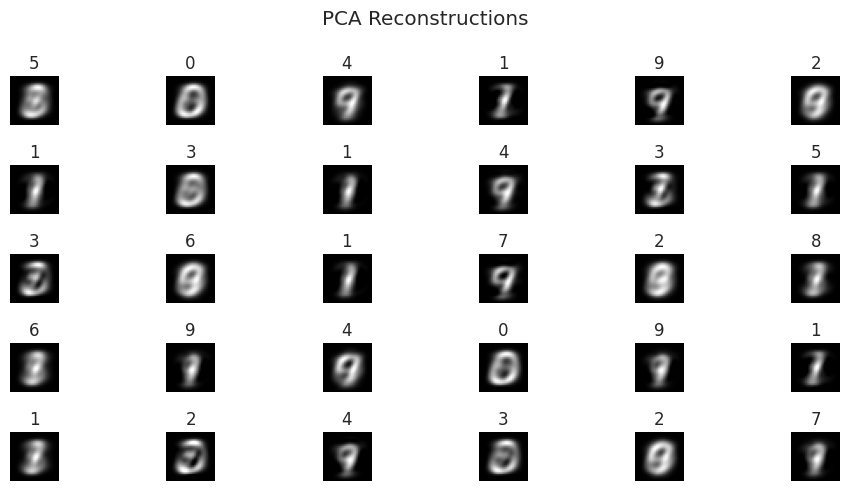

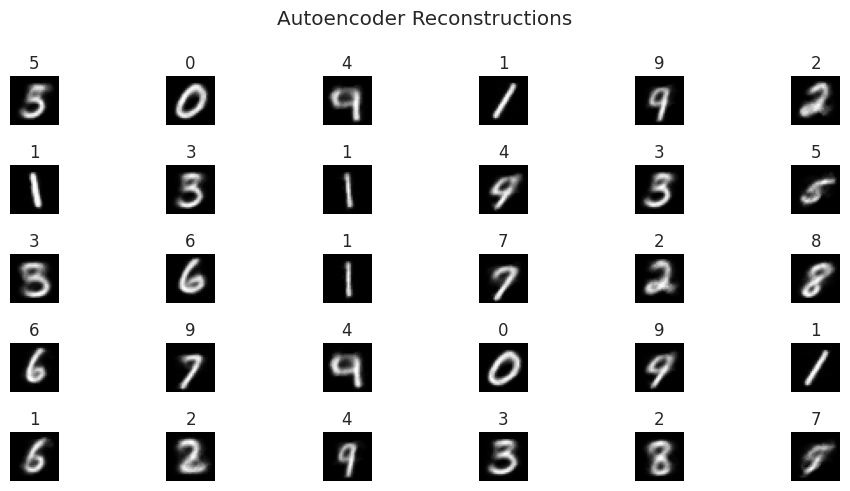

In [11]:
# --- Visualisation: Reconstruction ---
indices = np.arange(30)
x_train_plot = x_train[indices].reshape(-1, 28, 28)
x_train_ae_plot = R_ae[indices].reshape(-1, 28, 28)
x_train_pca_plot = R_pca[indices].reshape(-1, 28, 28)
x_train_pca_plot = np.clip(x_train_pca_plot, 0, 1)
y_train_plot = y_train[indices]

def plot_mnist(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(5, 6, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_mnist(x_train_plot, y_train_plot, "Original Images")
plot_mnist(x_train_pca_plot, y_train_plot, "PCA Reconstructions")
plot_mnist(x_train_ae_plot, y_train_plot, "Autoencoder Reconstructions")
